In [187]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from keras.losses import binary_crossentropy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

In [188]:
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 

In [189]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#transform to one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [190]:
# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [191]:
original_dim = X_train.shape[1]
latent_dim = 8
intermediate_dim = 256

In [192]:
#input layer
inputs = Input(shape=(original_dim,))
labels = Input(shape=(2,))

#dense layer with relu activation
h = Dense(intermediate_dim, activation='relu')(inputs)

In [193]:
## encoder model ##

# parameters of latent distribution
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [194]:
# sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [195]:
# sample vector from latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [196]:
# classifier
classifier_h = Dense(intermediate_dim, activation='relu')(z)
classifier_output = Dense(2, activation='softmax')(classifier_h)

In [197]:
### Decoder model ###

# Dense layer with relu activation takes sampled latent space vector z and maps it to an intermediate space
decoder_h = Dense(intermediate_dim, activation='relu')

# Dense layer with sigmoid activation takes the intermediate space vector and maps it back to the original dimension
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [198]:
# VAE model
vae = Model([labels, inputs], [x_decoded_mean,classifier_output])

In [199]:
# Define the VAE loss

# Reconstruction loss
rec_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
# KL divergence loss 
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#classifier loss
class_loss = binary_crossentropy(labels, classifier_output)
# Total loss
vae_loss = K.mean(rec_loss + kl_loss + class_loss)



In [200]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [201]:
# Train the VAE model
vae.fit([y_train, X_train], epochs=100, batch_size=64, validation_data=([y_test, X_test], None))

Epoch 1/100
58/58 [==============================] - 3s 9ms/step - loss: 21.3978 - val_loss: -2.3767
Epoch 2/100
58/58 [==============================] - 0s 5ms/step - loss: -206.7661 - val_loss: -924.5719
Epoch 3/100
58/58 [==============================] - 0s 5ms/step - loss: -6967.2339 - val_loss: -19175.1328
Epoch 4/100
58/58 [==============================] - 0s 5ms/step - loss: -58465.6406 - val_loss: -118349.6328
Epoch 5/100
58/58 [==============================] - 0s 6ms/step - loss: -251204.1094 - val_loss: -423812.5938
Epoch 6/100
58/58 [==============================] - 0s 6ms/step - loss: -735080.6875 - val_loss: -1097874.1250
Epoch 7/100
58/58 [==============================] - 0s 5ms/step - loss: -1705050.5000 - val_loss: -2352382.2500
Epoch 8/100
58/58 [==============================] - 0s 5ms/step - loss: -3371653.5000 - val_loss: -4425654.0000
Epoch 9/100
58/58 [==============================] - 0s 5ms/step - loss: -5961135.5000 - val_loss: -7560185.0000
Epoch 10/100
5

In [202]:
# Build the encoder model 
encoder = Model(inputs, [z_mean, z_log_var])
z_mean, z_log_var = encoder.predict(X_test, batch_size=64)

15/15 [==============================] - 0s 2ms/step


In [203]:
# locate data points in latent space
data_point = X_test[0]
data_point_encoding = [z_mean[0], z_log_var[0]]

In [204]:
# draw 5 samples from the latent distribution
epsilon = np.random.normal(size=(5, latent_dim))
z_sample = data_point_encoding[0] + np.exp(data_point_encoding[1] / 2) * epsilon

In [205]:
# build decoder model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

In [206]:
# decode samples
x_decoded = decoder.predict(z_sample)

1/1 [==============================] - 0s 73ms/step


In [207]:
# visualize decoded samples and original data point
print("Original data point:")
print(data_point)
print("Decoded samples:")
print(x_decoded)

Original data point:
[-0.34056358 -0.16631005 -0.55174471 -0.04948001 -0.4726319  -0.34453638
 -0.28844537 -0.28911937 -0.32243754 -0.37278906 -0.29632356 -0.64103532
  8.26699206 -0.17544014 -0.18879161 -0.28925083 -0.32224571 -0.34419436
  0.55005694 -0.16706796  0.80936442 -0.1148269   2.16605791 -0.2217132
 -0.33014887 -0.29650289 -0.22853303 -0.23434843 -0.16669638 -0.22378589
 -0.15845222 -0.14240594 -0.17152212 -0.14341561 -0.19628761 -0.23662691
 -0.32306004 -0.06039649 -0.18864868 -0.18471202 -0.11437955 -0.17985576
 -0.20058389 -0.14598088 -0.3044747  -0.1934785  -0.064924   -0.10621441
  0.42478664 -0.49688817 -0.14526526  4.31689398 -0.29823892 -0.09222286
  0.26272465  0.08774122 -0.14309771]
Decoded samples:
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  2.9422737e-13 9.9890029e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.000000

In [208]:
visualization_data = np.vstack(list(X_test[1:])+ [data_point] + list(x_decoded))

In [209]:
# Create labels for the visualization
labels = ["other data point in X_test"]*len(X_test[1:]) + ["Original data point"] + ["Generated"]*5
colors = ["darkslategray"]*len(X_test[1:]) + ["red"] + ["sienna"]*5

In [210]:
# Apply UMAP for visualization
umap_model = umap.UMAP(n_components=2)
visualized_data = umap_model.fit_transform(visualization_data)

/Users/hannah/anaconda3/envs/research_seminar/lib/python3.10/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


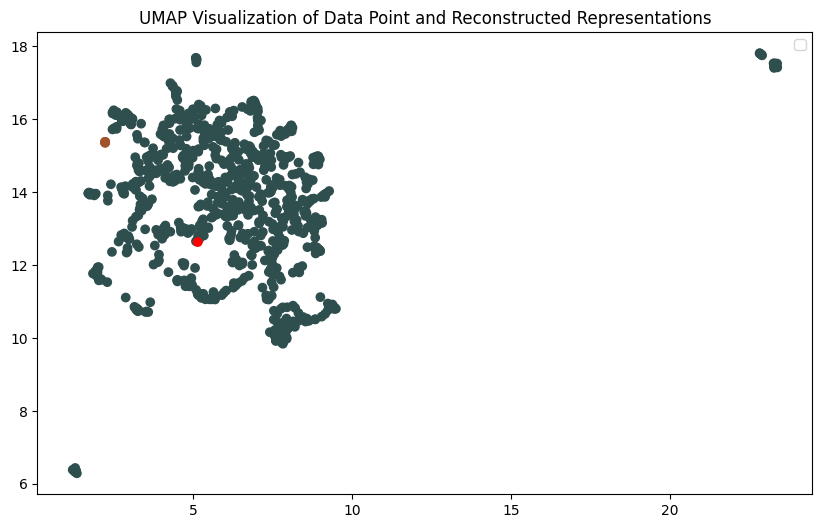

In [211]:
# Plot the visualization
plt.figure(figsize=(10, 6))
#scatter = plt.scatter(visualized_data[:, 0], visualized_data[:, 1], c=range(len(labels)), cmap='viridis')
scatter = plt.scatter(visualized_data[:, 0], visualized_data[:, 1], c=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.title('UMAP Visualization of Data Point and Reconstructed Representations')
plt.show()